Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License. 

# Training Quicknat with 2D slices from 3D volumes

This tutorial shows how to train a quicknat network with 2D samples from 3D inputs.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/modules/2d_segmentation_quicknat.ipynb)

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm, nibabel]"
%matplotlib inline

## Setup imports



In [2]:
import logging
import os
import tempfile

from glob import glob

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import torch

import monai
from monai.apps.utils import download_and_extract
from monai.data import DataLoader, CacheDataset, create_test_image_3d, list_data_collate
from monai.inferers import sliding_window_inference
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
from monai.networks.nets import Quicknat
from monai.networks.utils import one_hot
from monai.transforms import Compose, EnsureChannelFirstd, LoadImaged, ScaleIntensityd
from monai.utils import set_determinism
from monai.visualize import matshow3d


monai.config.print_config()
set_determinism(0)

log = logging.getLogger(__name__)

MONAI version: 1.1.0
Numpy version: 1.23.0
Pytorch version: 1.13.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /Users/carlottaholzle/Desktop/CAPS/monai_networks/.venv1/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.4.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.14.1
tqdm version: 4.64.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.4
pandas version: 1.5.2
einops version: 0.4.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    http

## Setup data directory 
You can specify a directory with the `directory` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.
With `use_synthetic_data` you can specify if training should be done with OASIS MRI Brainscans (`use_synthetic_data` = False) or if you want to generate random volumes (`use_synthetic_data` = True)
`num_seg_classes` should be label.max()+1

In [22]:
# specifiy which data to use
use_synthetic_data = False
num_seg_classes = 4
# view used for training:
view = "sagital"
directory = ""
root_dir = tempfile.mkdtemp() if directory is None else directory
data_dir = os.path.join(root_dir, "synthetic_data" if use_synthetic_data else "OASIS-1/disc1")
print(f"Root directory: {root_dir}")
print(f"Data directory: {data_dir}")

Root directory: 
Data directory: OASIS-1/disc1


## Load dataset if `use_synthetic_data` = False. 
The volumes are downloaded from "https://www.oasis-brains.org".
The volumes provided have 3 segmentation classes.

In [ ]:
# Download and extract, if needed OASIS Data
if not use_synthetic_data:
    print("Using OASIS data")
    resource = "https://download.nrg.wustl.edu/data/oasis_cross-sectional_disc1.tar.gz"
    md5 = "c83e216ef8654a7cc9e2a30a4cdbe0cc"

    compressed_file = os.path.join(root_dir, "oasis_cross-sectional_disc1.tar.gz")
    print(f"Downloading into {data_dir} if the Oasis data is not already downloaded.")
    # download the data only if it doesn't exist in your data directory:
    if not os.path.exists(data_dir):
        download_and_extract(resource, compressed_file, data_dir, md5)

    image_path_expression = "PROCESSED/MPRAGE/T88_111/OAS1_*_MR*_mpr_n*_anon_111_t88_masked_gfc.img"
    segmentation_path_expression = "FSL_SEG/OAS1_*_MR*_mpr_n*_anon_111_t88_masked_gfc_fseg.img"
    image_paths = glob(os.path.join(data_dir, "*", image_path_expression))
    print(image_paths[0])
    image_paths += glob(os.path.join(data_dir, "*/*", image_path_expression))
    segmentation_paths = glob(os.path.join(data_dir, "*", segmentation_path_expression))
    segmentation_paths += glob(os.path.join(data_dir, "*/*", segmentation_path_expression))

## Create a dataset if `use_synthetic_data` = True

The example volumes are created with different spatial shapes for demo purposes. 
You can set `num_seg_classes` depending on how many segmentation classes you want to have. 

In [5]:
if use_synthetic_data:
    if use_synthetic_data:
        print(f"generating synthetic data to {root_dir} (this may take a while)")
        for i in range(40):
            # make the input volumes same size as the OASIS data
            H, W, D = 176, 208, 176
            im, seg = create_test_image_3d(H, W, D, num_seg_classes=(num_seg_classes - 1), channel_dim=-1, rad_max=10)

            n = nib.Nifti1Image(im, np.eye(4))
            nib.save(n, os.path.join(data_dir, f"img{i:d}.nii.gz"))
            n = nib.Nifti1Image(seg, np.eye(4))
            nib.save(n, os.path.join(data_dir, f"seg{i:d}.nii.gz"))

        image_paths = sorted(glob(os.path.join(data_dir, "img*.nii.gz")))
        segmentation_paths = sorted(glob(os.path.join(data_dir, "seg*.nii.gz")))

#### Select the number of patients available for training and testing

In [6]:
num_segs_to_select_train = 5
num_segs_to_select_test = 2 + num_segs_to_select_train
image_paths_train = image_paths[:num_segs_to_select_train]
segmentation_paths_train = segmentation_paths[:num_segs_to_select_train]
image_paths_test = image_paths[num_segs_to_select_train:num_segs_to_select_test]
segmentation_paths_test = segmentation_paths[num_segs_to_select_train:num_segs_to_select_test]

### Split the images in the different views 
[i,:,:,0] sagital - [:, i, : , 0] coronal - [:, : , i, 0] axial

In [7]:
# Change folder and axis iterator

folder_images = os.path.join(directory, "Split_train", view)
folder_labels = os.path.join(directory, "Split_train", view, "labels")

for images_name, labels_name in zip(image_paths_train, segmentation_paths_train):
    images = nib.load(images_name)
    labels = nib.load(labels_name)

    for i in range(images.shape[0]):
        if i > 18 and i < 155:
            name_img = folder_images + images_name[66:75] + "_" + str(i).zfill(4) + ".nii"
            name_seg = folder_labels + labels_name[49:58] + "_" + str(i).zfill(4) + ".nii"
            # [i,:,:,0] sagital
            # [:, i, : , 0] coronal
            # [:, : , i, 0] axial
            slice_images = images.get_fdata()[:, i, :, 0]
            slice_labels = labels.get_fdata()[:, i, :, 0]
            nifti_slice = nib.Nifti1Image(slice_images, np.eye(4))
            nib.save(nifti_slice, name_img)
            nifti_slice = nib.Nifti1Image(slice_labels, np.eye(4))
            nib.save(nifti_slice, name_seg)

very large origin values relative to dims; leaving as set, ignoring for affine


2023-02-17 12:16:09,978 - very large origin values relative to dims; leaving as set, ignoring for affine


very large origin values relative to dims; leaving as set, ignoring for affine


2023-02-17 12:16:09,982 - very large origin values relative to dims; leaving as set, ignoring for affine


very large origin values relative to dims; leaving as set, ignoring for affine


2023-02-17 12:16:09,986 - very large origin values relative to dims; leaving as set, ignoring for affine


very large origin values relative to dims; leaving as set, ignoring for affine


2023-02-17 12:16:09,987 - very large origin values relative to dims; leaving as set, ignoring for affine


very large origin values relative to dims; leaving as set, ignoring for affine


2023-02-17 12:16:10,192 - very large origin values relative to dims; leaving as set, ignoring for affine


very large origin values relative to dims; leaving as set, ignoring for affine


2023-02-17 12:16:10,193 - very large origin values relative to dims; leaving as set, ignoring for affine


very large origin values relative to dims; leaving as set, ignoring for affine


2023-02-17 12:16:10,196 - very large origin values relative to dims; leaving as set, ignoring for affine


very large origin values relative to dims; leaving as set, ignoring for affine


2023-02-17 12:16:10,198 - very large origin values relative to dims; leaving as set, ignoring for affine


very large origin values relative to dims; leaving as set, ignoring for affine


2023-02-17 12:16:10,381 - very large origin values relative to dims; leaving as set, ignoring for affine


very large origin values relative to dims; leaving as set, ignoring for affine


2023-02-17 12:16:10,383 - very large origin values relative to dims; leaving as set, ignoring for affine


very large origin values relative to dims; leaving as set, ignoring for affine


2023-02-17 12:16:10,385 - very large origin values relative to dims; leaving as set, ignoring for affine


very large origin values relative to dims; leaving as set, ignoring for affine


2023-02-17 12:16:10,387 - very large origin values relative to dims; leaving as set, ignoring for affine


very large origin values relative to dims; leaving as set, ignoring for affine


2023-02-17 12:16:10,536 - very large origin values relative to dims; leaving as set, ignoring for affine


very large origin values relative to dims; leaving as set, ignoring for affine


2023-02-17 12:16:10,537 - very large origin values relative to dims; leaving as set, ignoring for affine


very large origin values relative to dims; leaving as set, ignoring for affine


2023-02-17 12:16:10,540 - very large origin values relative to dims; leaving as set, ignoring for affine


very large origin values relative to dims; leaving as set, ignoring for affine


2023-02-17 12:16:10,541 - very large origin values relative to dims; leaving as set, ignoring for affine


very large origin values relative to dims; leaving as set, ignoring for affine


2023-02-17 12:16:10,696 - very large origin values relative to dims; leaving as set, ignoring for affine


very large origin values relative to dims; leaving as set, ignoring for affine


2023-02-17 12:16:10,697 - very large origin values relative to dims; leaving as set, ignoring for affine


very large origin values relative to dims; leaving as set, ignoring for affine


2023-02-17 12:16:10,700 - very large origin values relative to dims; leaving as set, ignoring for affine


very large origin values relative to dims; leaving as set, ignoring for affine


2023-02-17 12:16:10,702 - very large origin values relative to dims; leaving as set, ignoring for affine


#### The file sturcture should now look like this: 

In [ ]:
# Quicknat_folder structure should look like:
#       -> coronal
#           img1.nii
#             ->lables
#                 seg1.nii
#       -> sagital
#           img1.nii
#             ->lables
#                 seg1.nii
#       ->axial
#           img1.nii
#             ->lables
#                 seg1.nii

## Files list to dataloader

In [ ]:
datadir_train = os.path.join(directory, "Split_train", view)
print(datadir_train)
images = sorted(glob(os.path.join(datadir_train, "*.nii")))
segs = sorted(glob(os.path.join(datadir_train, "labels", "*.nii")))
print("total number of images available: ", len(images))
print("total number of segmentation available: ", len(segs))
# select the images to use for training and validation
# one patient has 176 images per view. If more than 150 images are considered
# be aware to take out the first and last black images of each patient before starting training
train_split = 90
val_split = 10 + train_split
# starting at image 30 as the first images are only black slices without useful information
train_files = [{"img": img, "seg": seg} for img, seg in zip(images[30:train_split], segs[30:train_split])]
val_files = [{"img": img, "seg": seg} for img, seg in zip(images[train_split:val_split], segs[train_split:val_split])]
print("number of images used for training: ", len(train_files))
print("number of images used for validation: ", len(val_files))

## Create dataloaders

In [10]:
# define transforms for image and segmentation
train_transforms = Compose(
    [LoadImaged(keys=["img", "seg"]), EnsureChannelFirstd(keys=["img", "seg"]), ScaleIntensityd(keys=["img"])]
)

# CHECK TRANSFORMS
check_ds = monai.data.Dataset(data=train_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=2, collate_fn=list_data_collate)
check_data = monai.utils.misc.first(check_loader)
print(check_data["img"].shape, check_data["seg"].shape)


# create a training data loader
# train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)
train_ds = CacheDataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=1, shuffle=False, collate_fn=list_data_collate, pin_memory=True)

# create a validation data loader
val_ds = CacheDataset(data=val_files, transform=train_transforms)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, collate_fn=list_data_collate, pin_memory=True)

torch.Size([2, 1, 208, 176]) torch.Size([2, 1, 208, 176])


Loading dataset: 100%|██████████| 10/10 [00:00<00:00, 233.54it/s]


## Define 2D QuickNAT network and work with DiceCELoss function

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# set same num_classes as defined when loading data
model = Quicknat(num_classes=num_seg_classes, se_block=None)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
loss_function = DiceCELoss(include_background=True, to_onehot_y=True, softmax=True)
# the version of the model you are training
version = 1

### Training loop for monai Quicknat Model

----------
epoch 1/20


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


20, train_loss: 0.8436
40, train_loss: 0.7249
60, train_loss: 0.4201
saved new best metric model
current epoch: 1 current mean dice: 0.8054
best mean dice: 0.8054 at epoch: 1
epoch 1 average loss: 0.8374
----------
epoch 2/20
20, train_loss: 0.3021
40, train_loss: 0.4076
60, train_loss: 0.2602
saved new best metric model
current epoch: 2 current mean dice: 0.8079
best mean dice: 0.8079 at epoch: 2
epoch 2 average loss: 0.3586
----------
epoch 3/20
20, train_loss: 0.2160
40, train_loss: 0.3191
60, train_loss: 0.2441
saved new best metric model
current epoch: 3 current mean dice: 0.8094
best mean dice: 0.8094 at epoch: 3
epoch 3 average loss: 0.2981
----------
epoch 4/20
20, train_loss: 0.1906
40, train_loss: 0.3513
60, train_loss: 0.2198
current epoch: 4 current mean dice: 0.7897
best mean dice: 0.8094 at epoch: 3
epoch 4 average loss: 0.2837
----------
epoch 5/20
20, train_loss: 0.1701
40, train_loss: 0.3611
60, train_loss: 0.2149
current epoch: 5 current mean dice: 0.7750
best mean di

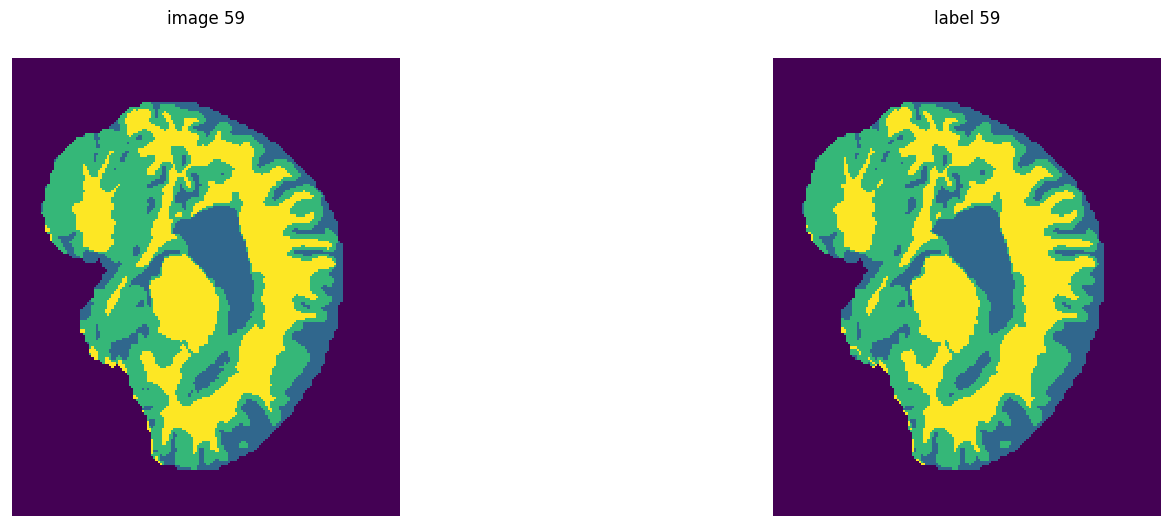

In [12]:
max_epochs = 20
epoch_loss_values = []
all_loss_values = []
val_interval = 1
metric_values = []
best_metric = -1
best_metric_epoch = -1
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
for _ in range(max_epochs):
    all_loss_values.append([])
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss, step = 0, 0
    epocharray = all_loss_values[epoch - 1]
    for i, batch_data in enumerate(train_loader):
        step += 1
        inputs, labels = batch_data["img"].to(device), batch_data["seg"].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)  # [1, 4, 208, 176]

        plt.figure("check", (18, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"image {i}")
        temp = torch.argmax(outputs, dim=1, keepdim=False)
        matshow3d(temp, fig=plt.gca())
        plt.subplot(1, 2, 2)
        plt.title(f"label {i}")
        matshow3d(labels, fig=plt.gca())
        if i == 58:
            filename = "V" + str(version) + "epoch_" + str(epoch + 1) + "step_" + str(step) + ".png"
            plt.savefig((os.path.join(directory, "predictionValidation", view, filename)))
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        if step % 20 == 0:
            print(f"{step}, train_loss: {loss.item():.4f}")

        all_loss_values[epoch].append(loss.item())

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["img"].to(device),
                    val_data["seg"].to(device),
                )
                roi_size = (208, 176)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
                labels_onehot = one_hot(val_labels, num_seg_classes)

                # compute metric for current iteration
                dice_metric(y_pred=val_outputs > 0.5, y=labels_onehot)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(
                    model.state_dict(),
                    os.path.join(directory, "model", view, ("V" + str(version) + "best_metric_model.pth")),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
print("train completed")

## Check best model output with the input image and label

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


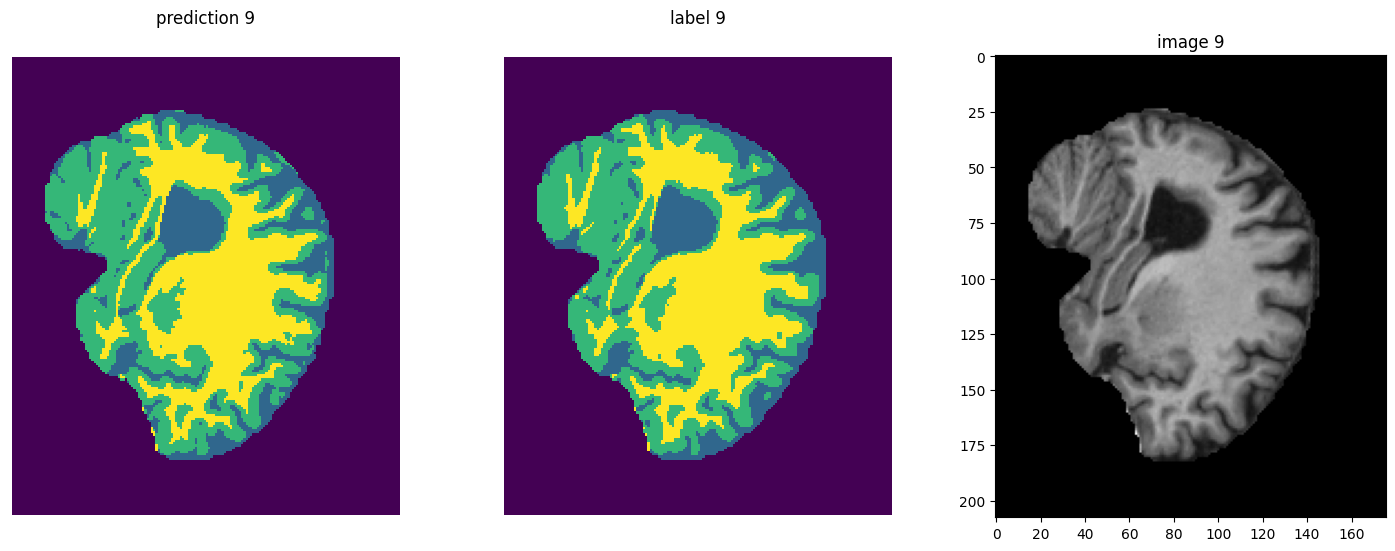

In [13]:
model.load_state_dict(
    torch.load(os.path.join(directory, "model", view, ("V" + str(version) + "best_metric_model.pth")))
)
for i, batch_data in enumerate(val_loader):
    inputs, labels = batch_data["img"].to(device), batch_data["seg"].to(device)
    outputs = model(inputs)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title(f"prediction {i}")
    temp = torch.argmax(outputs, dim=1, keepdim=False)
    matshow3d(temp, fig=plt.gca())
    plt.subplot(1, 3, 2)
    plt.title(f"label {i}")
    matshow3d(labels, fig=plt.gca())
    plt.subplot(1, 3, 3)
    plt.title(f"image {i}")
    plt.imshow(torch.squeeze(inputs), cmap="gray")
    if i == 58:
        plt.savefig(
            os.path.join(directory, "predictionTest", view, ("V" + str(version) + "i_" + str(i) + "validation.png"))
        )
        plt.show()

## Visualize the loss values per epoch 

### Loss and Metric in one plot 

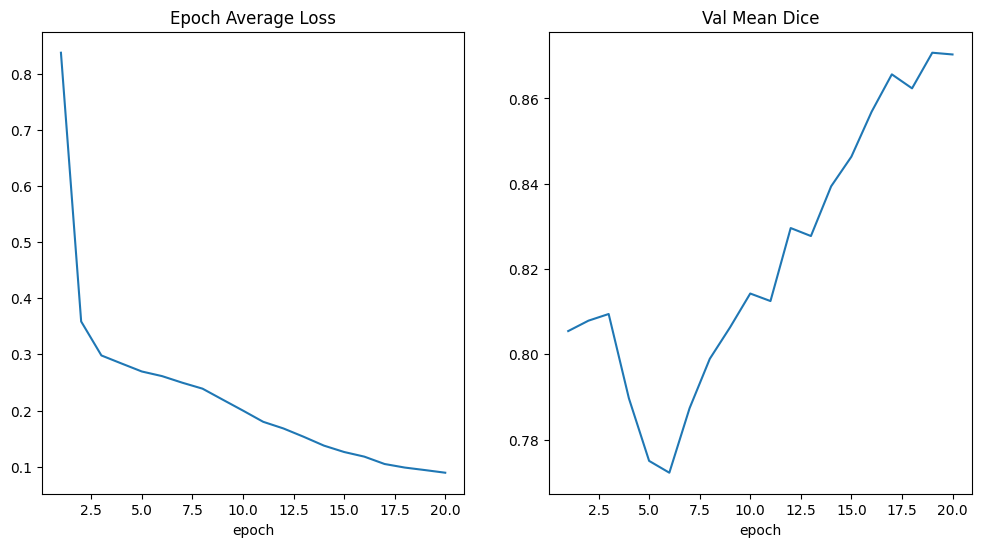

In [14]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.savefig(
    os.path.join(
        directory, "model", view, ("V" + str(version) + "metricsCL_epochs" + str(len(epoch_loss_values)) + ".png")
    )
)
plt.show()

## Inference

### Load inference images

In [15]:
# Change folder and axis iterator

folder_images = os.path.join(directory, "Split_test", view)
folder_labels = os.path.join(directory, "Split_test", view, "labels")

for images_name, labels_name in zip(image_paths_test, segmentation_paths_test):
    images = nib.load(images_name)
    labels = nib.load(labels_name)

    for i in range(images.shape[0]):
        if i > 18 and i < 155:
            name_img = folder_images + images_name[66:75] + "_" + str(i).zfill(4) + ".nii"
            name_seg = folder_labels + labels_name[49:58] + "_" + str(i).zfill(4) + ".nii"
            # make sure to slice the data according to the specified view
            slice_images = images.get_fdata()[:, i, :, 0]
            slice_labels = labels.get_fdata()[:, i, :, 0]
            nifti_slice = nib.Nifti1Image(slice_images, np.eye(4))
            nib.save(nifti_slice, name_img)
            nifti_slice = nib.Nifti1Image(slice_labels, np.eye(4))
            nib.save(nifti_slice, name_seg)
        # print(nifti_slice.shape)

very large origin values relative to dims; leaving as set, ignoring for affine


2023-02-17 13:29:35,036 - very large origin values relative to dims; leaving as set, ignoring for affine


very large origin values relative to dims; leaving as set, ignoring for affine


2023-02-17 13:29:35,042 - very large origin values relative to dims; leaving as set, ignoring for affine


very large origin values relative to dims; leaving as set, ignoring for affine


2023-02-17 13:29:35,049 - very large origin values relative to dims; leaving as set, ignoring for affine


very large origin values relative to dims; leaving as set, ignoring for affine


2023-02-17 13:29:35,053 - very large origin values relative to dims; leaving as set, ignoring for affine


very large origin values relative to dims; leaving as set, ignoring for affine


2023-02-17 13:29:35,392 - very large origin values relative to dims; leaving as set, ignoring for affine


very large origin values relative to dims; leaving as set, ignoring for affine


2023-02-17 13:29:35,394 - very large origin values relative to dims; leaving as set, ignoring for affine


very large origin values relative to dims; leaving as set, ignoring for affine


2023-02-17 13:29:35,403 - very large origin values relative to dims; leaving as set, ignoring for affine


very large origin values relative to dims; leaving as set, ignoring for affine


2023-02-17 13:29:35,406 - very large origin values relative to dims; leaving as set, ignoring for affine


In [ ]:
datadir_test = os.path.join(directory, "Split_test", view)
images = sorted(glob(os.path.join(datadir_test, "*.nii")))
segs = sorted(glob(os.path.join(datadir_test + "/labels", "*.nii")))
print("Number of images available: ", len(images))
print("Number of segmentation available: ", len(segs))
test_split = 60
test_files = [{"img": img, "seg": seg} for img, seg in zip(images[30:test_split], segs[30:test_split])]
print("First test file: ", test_files[0])
print("Number of images used for testing: ", len(test_files))

### Inference Dataloader

In [19]:
# define transforms for image and segmentation
train_transforms = Compose(
    [LoadImaged(keys=["img", "seg"]), EnsureChannelFirstd(keys=["img", "seg"]), ScaleIntensityd(keys=["img"])]
)
test_ds = CacheDataset(data=test_files, transform=train_transforms)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, collate_fn=list_data_collate, pin_memory=True)

Loading dataset: 100%|██████████| 30/30 [00:00<00:00, 142.40it/s]


### Inference on trained network 

Visualization

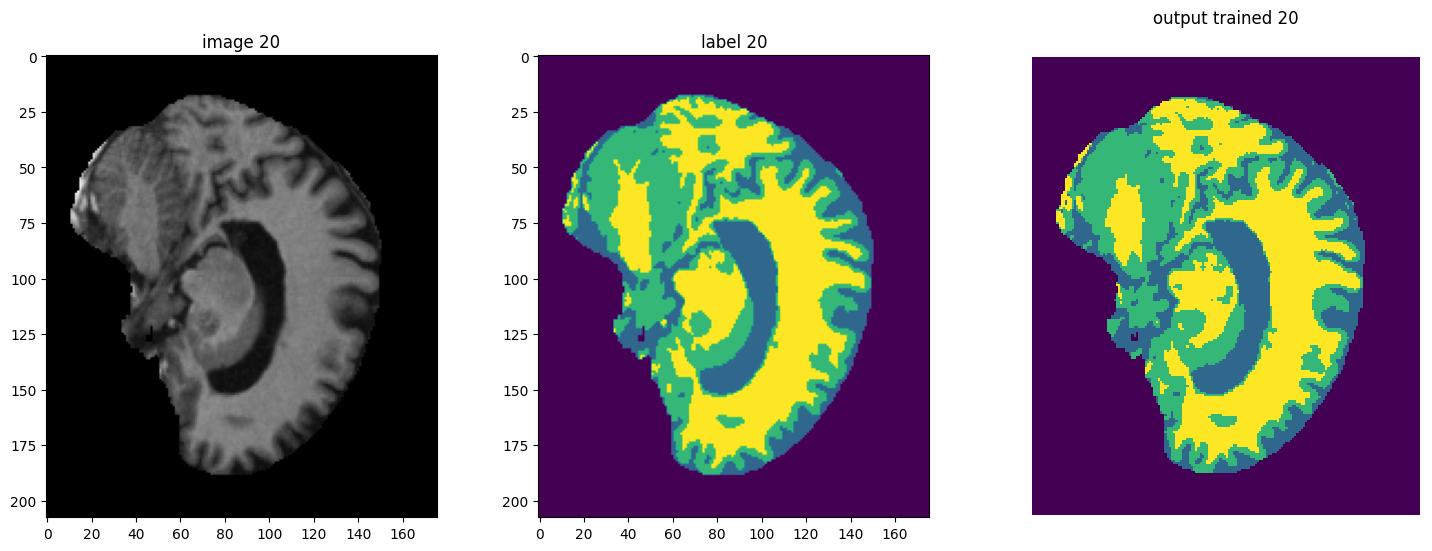

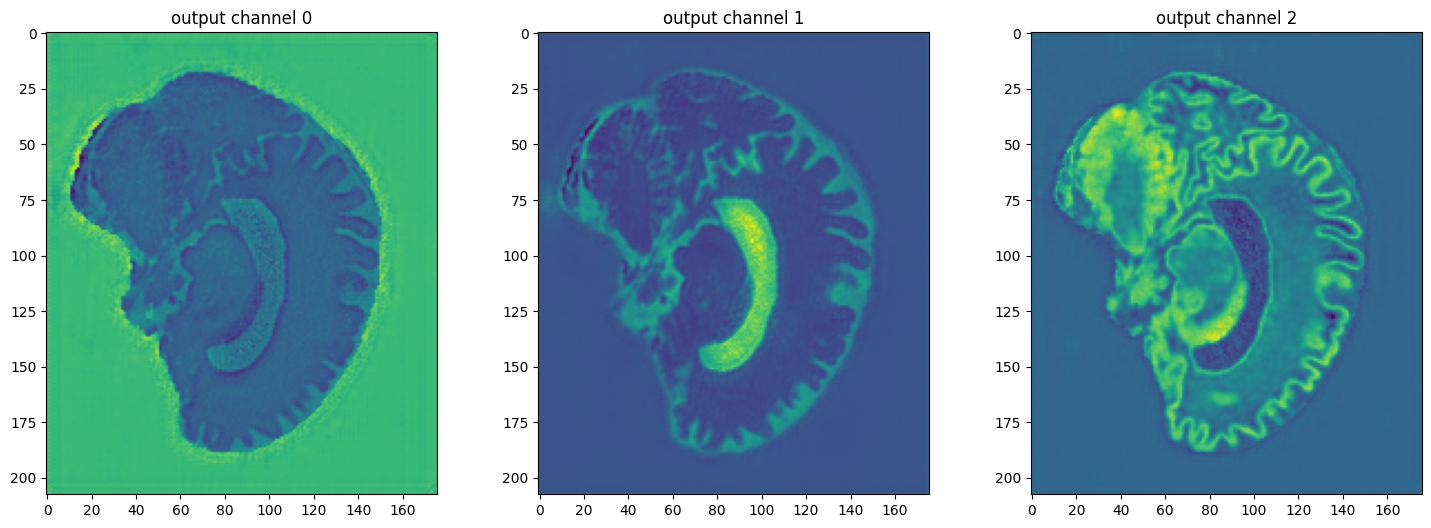

In [20]:
model.load_state_dict(
    torch.load(os.path.join(directory, "model", view, ("V" + str(version) + "best_metric_model.pth")))
)
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(test_loader):
        roi_size = (208, 176)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["img"].to(device), roi_size, sw_batch_size, model)
        if i == 20:
            plt.figure("comparing", (18, 6))
            plt.subplot(1, 3, 1)
            plt.title(f"image {i}")
            plt.imshow(torch.squeeze(val_data["img"].to(device)), cmap="gray")
            plt.subplot(1, 3, 2)
            plt.title(f"label {i}")
            plt.imshow(torch.squeeze(val_data["seg"].to(device)))
            plt.subplot(1, 3, 3)
            plt.title(f"output trained {i}")
            # idx = torch.argmax(val_outputs, dim=1)
            idx = torch.argmax(val_outputs, dim=1).detach().cpu()  # [1, 208, 176]
            matshow3d(idx, fig=plt.gca())
            plt.savefig(
                os.path.join(directory, "predictionTest", view, ("V" + str(version) + "CLscan" + str(i) + ".png"))
            )
            # visualizing the channels:
            plt.figure("channels", (18, 6))
            for i in range(3):
                plt.subplot(1, 3, i + 1)
                plt.title(f"output channel {i}")
                plt.imshow(val_outputs[0, i, :, :].detach().cpu())
            plt.show()

Computing Dice

In [21]:
model = Quicknat(num_classes=4)
model.load_state_dict(
    torch.load(os.path.join(directory, "model", view, ("V" + str(version) + "best_metric_model.pth")))
)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
model.eval()
metricAvg = 0
with torch.no_grad():
    for val_data in test_loader:
        val_inputs, val_labels = (
            val_data["img"].to(device),
            val_data["seg"].to(device),
        )
        roi_size = (208, 176)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_inputs, roi_size, sw_batch_size, model)
        labels_onehot = one_hot(val_labels, num_seg_classes)

        # compute metric for current iteration
        dice_metric(y_pred=val_outputs > 0.5, y=labels_onehot)
        metricAvg += dice_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()

# print("Metric on original image spacing: ", metric_values)
print("Average metric: ", metricAvg / len(test_loader))

Average metric:  0.8325567563374837
